 # Insurance Claims Severity

In [ ]:
## Objective
* In this project, you are asked to build a regression model to predict how sever is a claim given some information about a particular claim. You would want to take advantage of the knowledge you have learned about regression problems and apply it in a practical project like this.
* Please take a good documentation explain the steps of your data analysis process and also some comments for your code as well so that anyone who read your code could get a good understanding of what is going on.
* Explain your results in the context of the claim severity, and give some insights or conclusion about your whole analysis

In [24]:
## Import the necessary packages
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import preprocessing
# from sklearn import cross_validation
from sklearn.model_selection import cross_validate
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [25]:
train_data = pd.read_csv('Insurance Company Claims Security/train.csv')
train_size = train_data.shape[0]
test_data = pd.read_csv('Insurance Company Claims Security/test.csv')
test_size = test_data.shape[0]

## Merge train and test

In [26]:
full_data = pd.concat([train_data,test_data]).reset_index(drop=True)

## Group features

In [27]:
data_types = full_data.dtypes  
cat_cols = list(data_types[data_types=='object'].index)
con_cols = list(data_types[data_types=='int64'].index) + list(data_types[data_types=='float64'].index)

id_col = 'id'
target_col = 'loss'
con_cols.remove('id')
con_cols.remove('loss')

print ("Categorical features:", cat_cols)
print ( "Numerica features:", con_cols)
print ( "ID: %s, target: %s" %( id_col, target_col))

Categorical features: ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat1

## Some Data Exploration

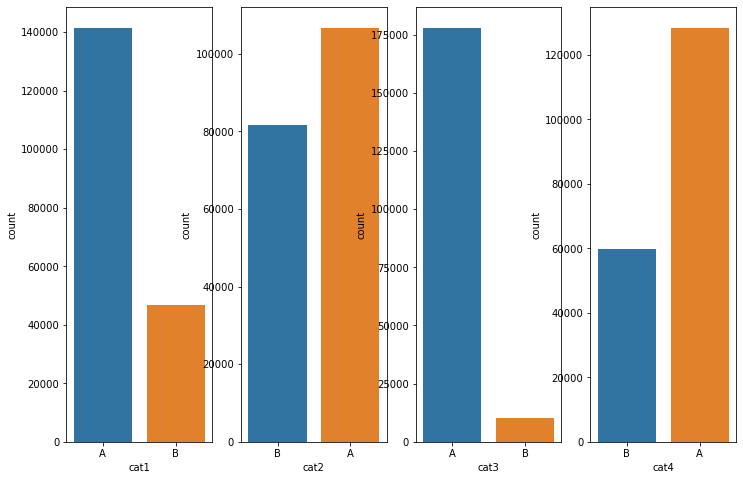

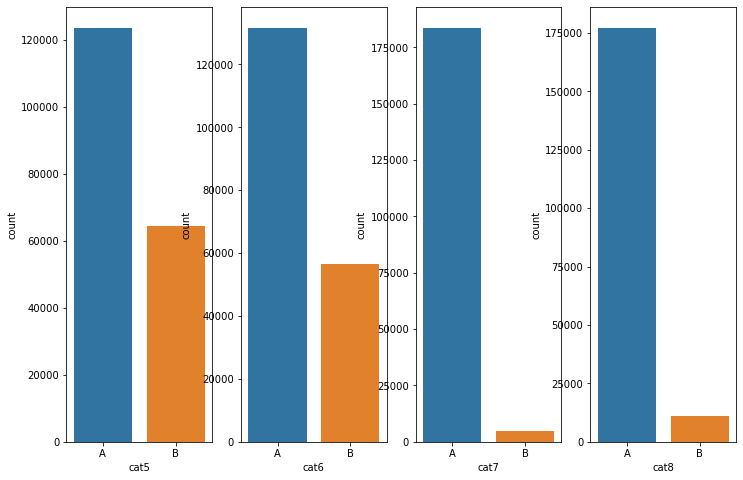

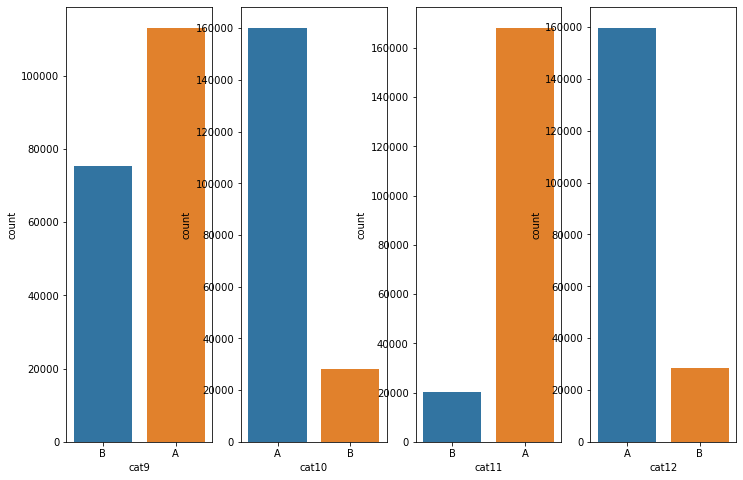

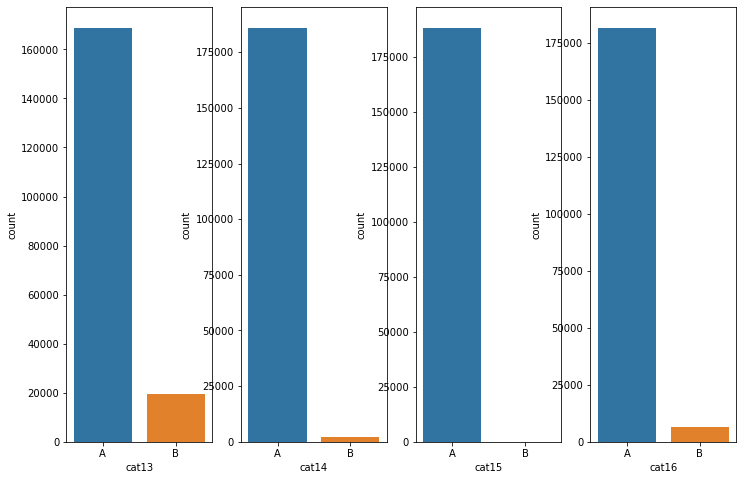

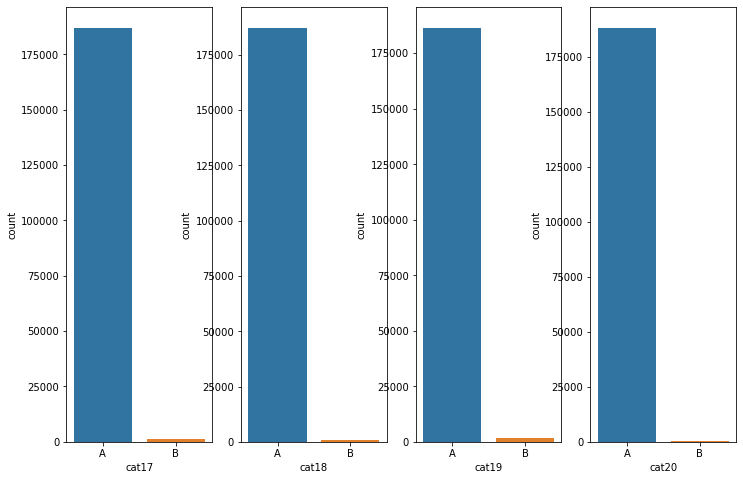

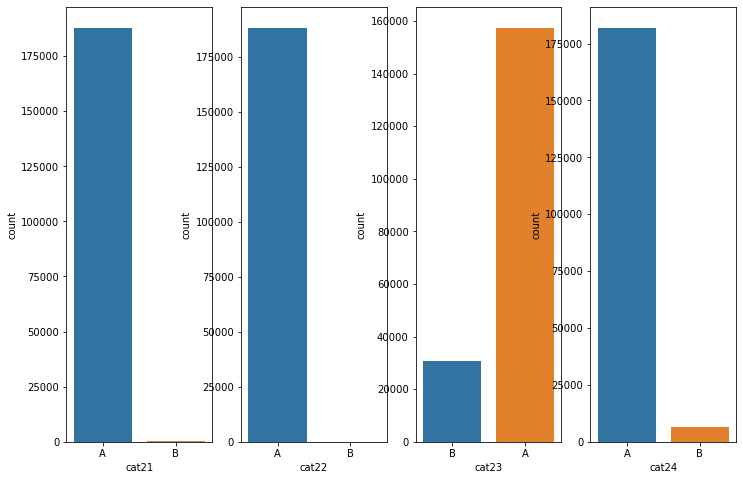

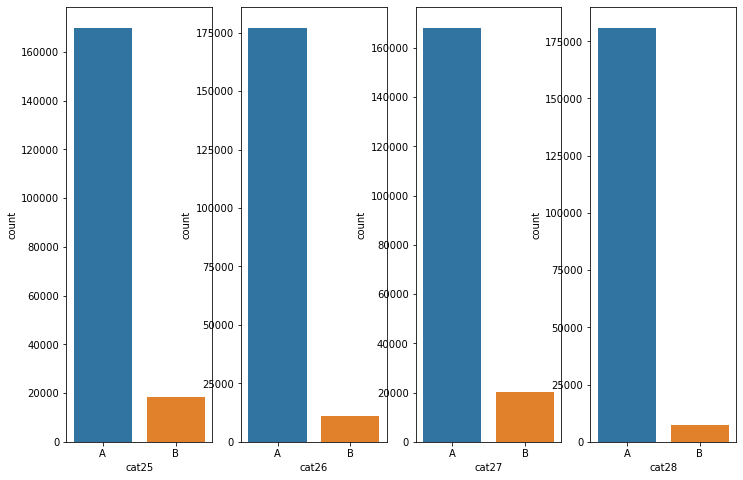

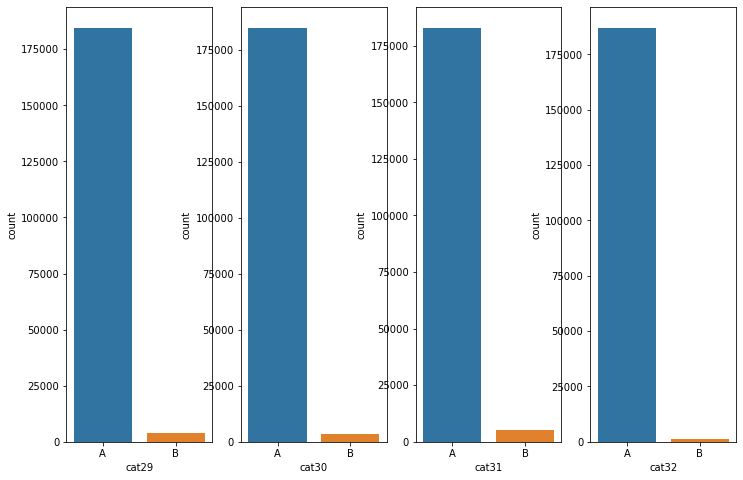

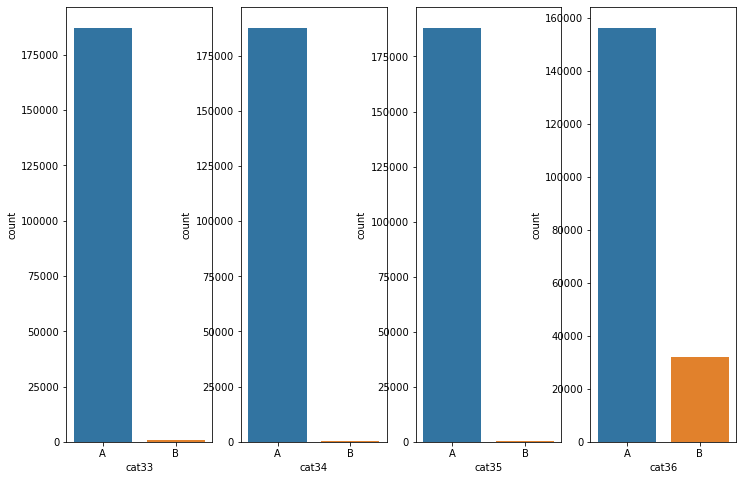

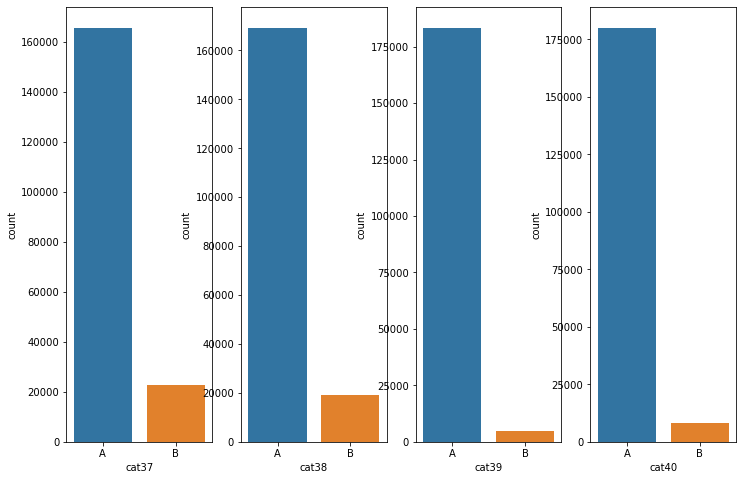

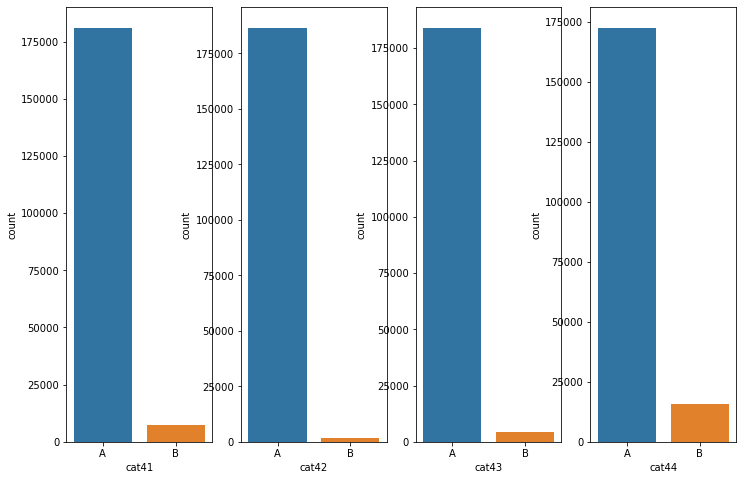

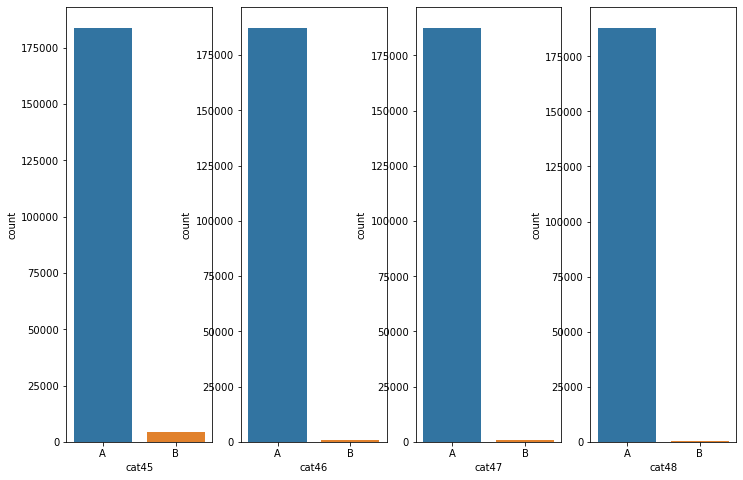

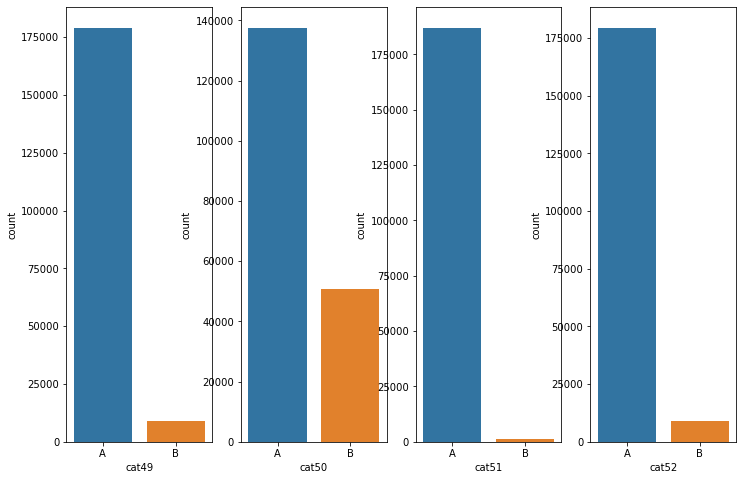

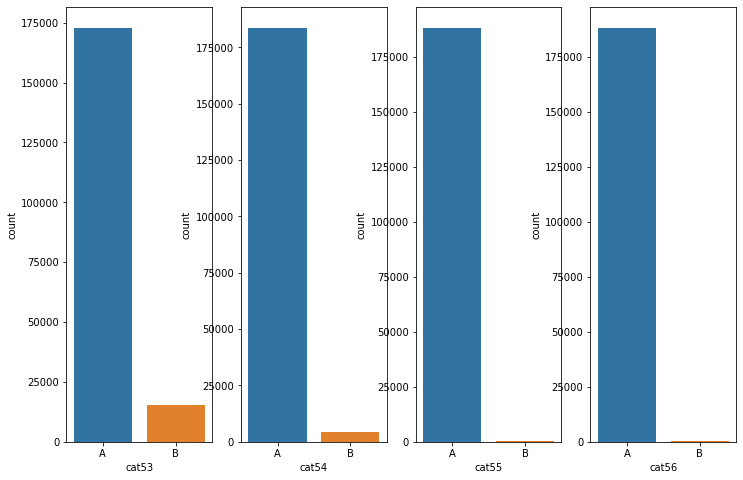

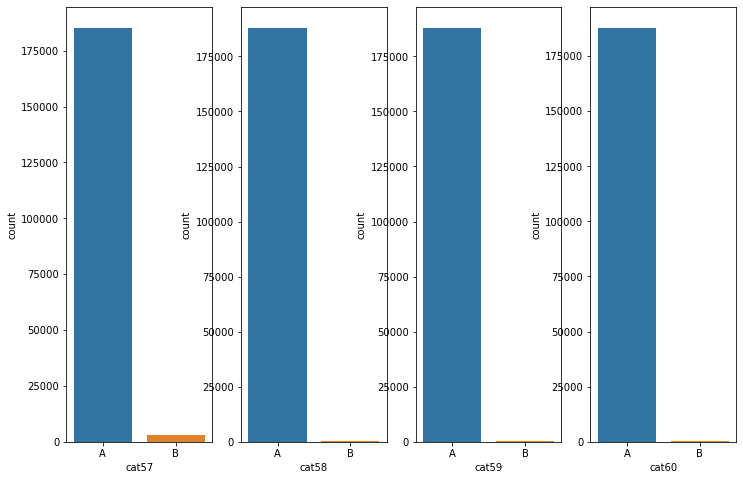

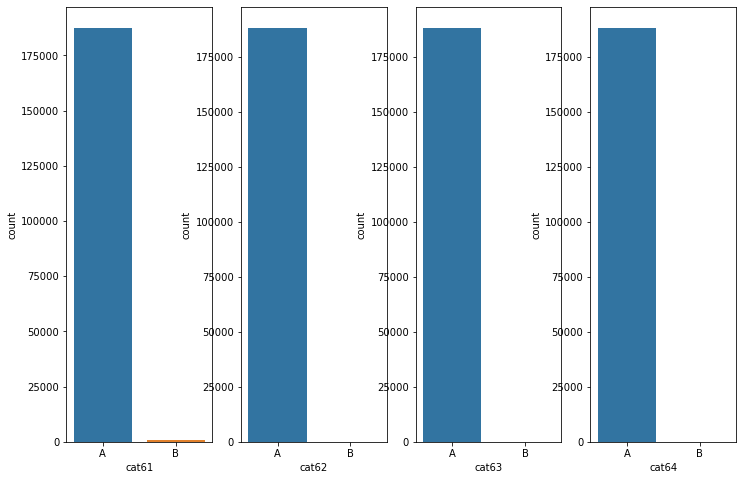

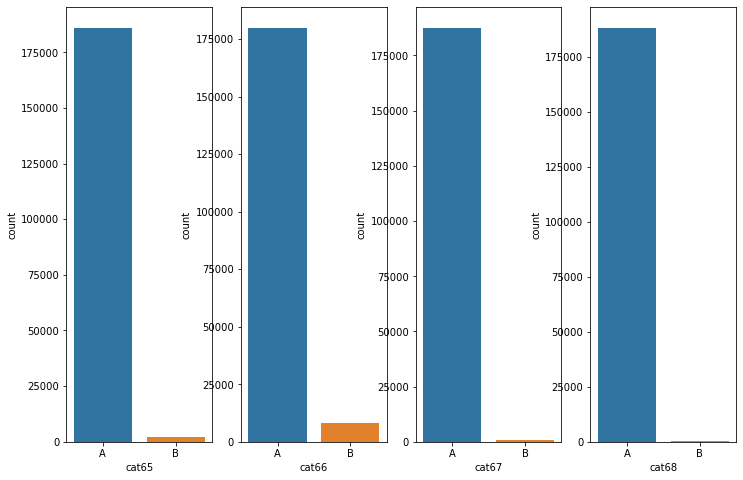

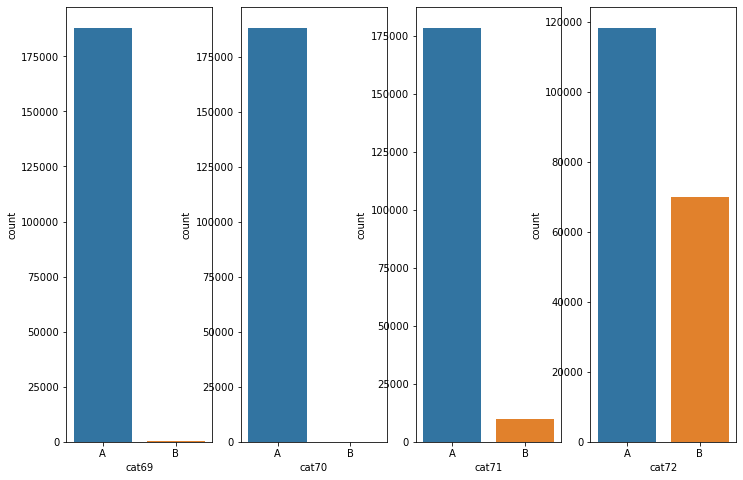

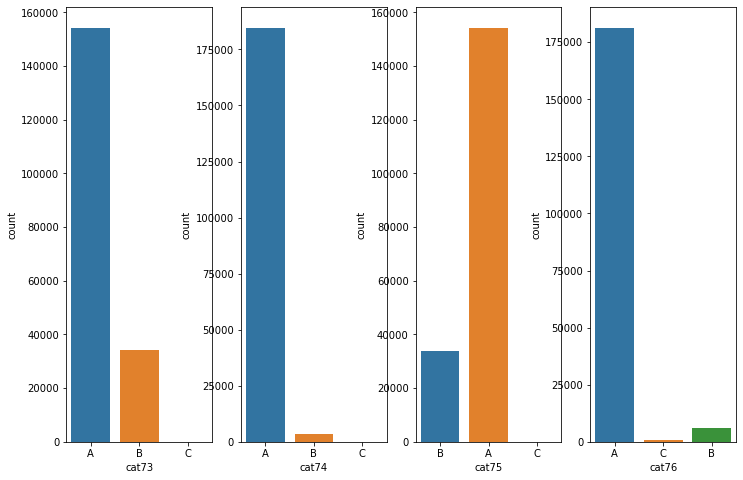

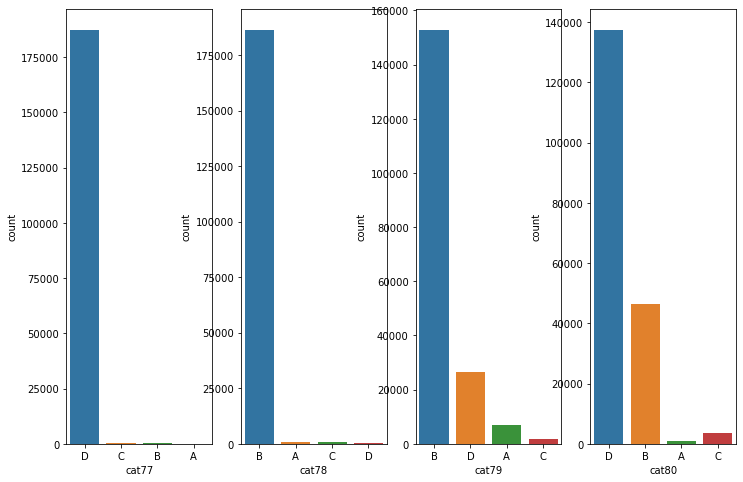

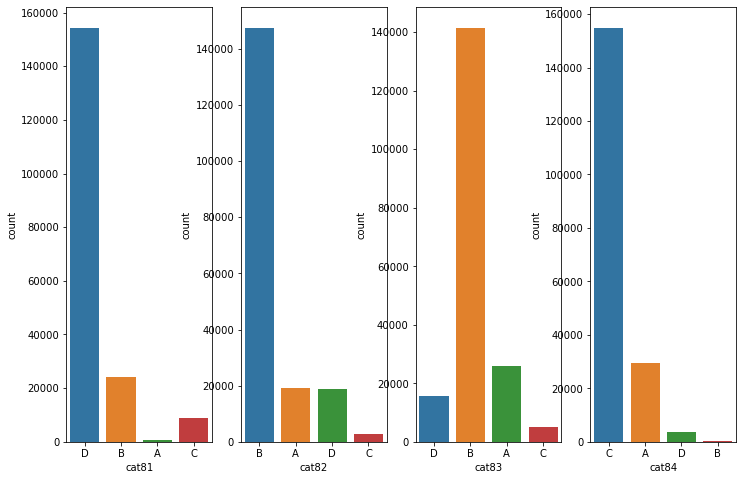

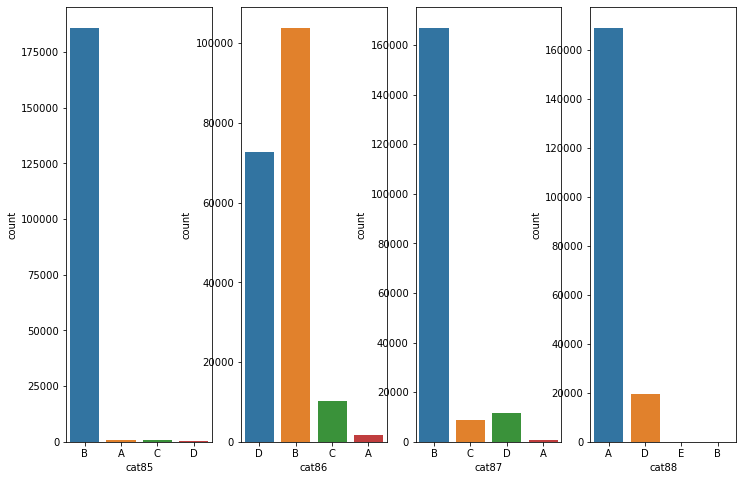

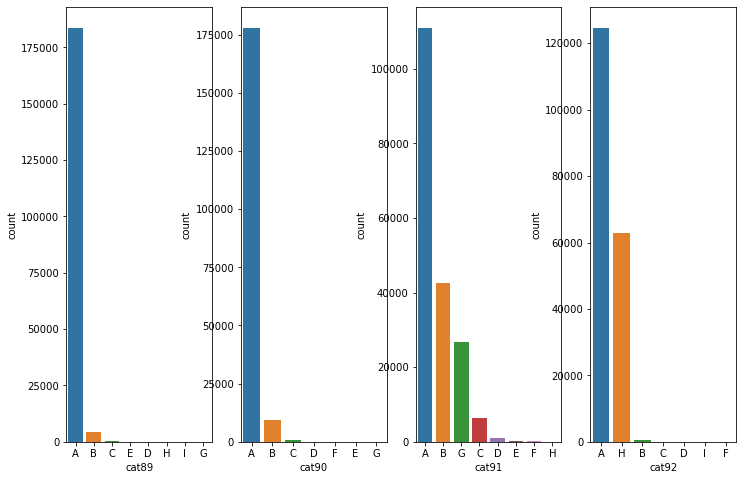

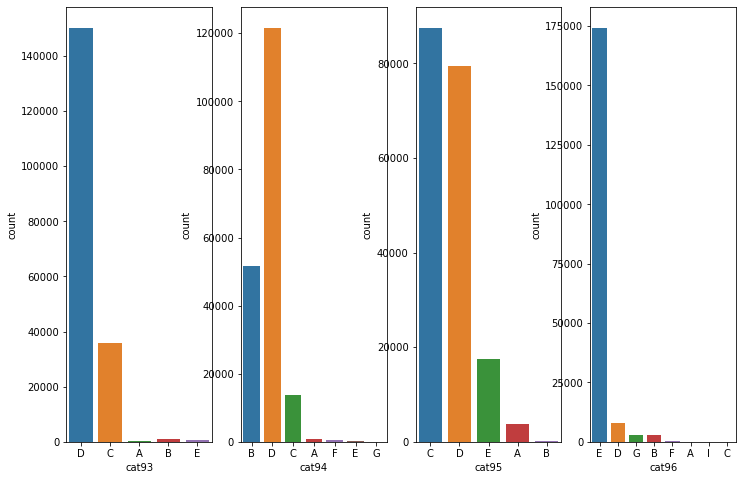

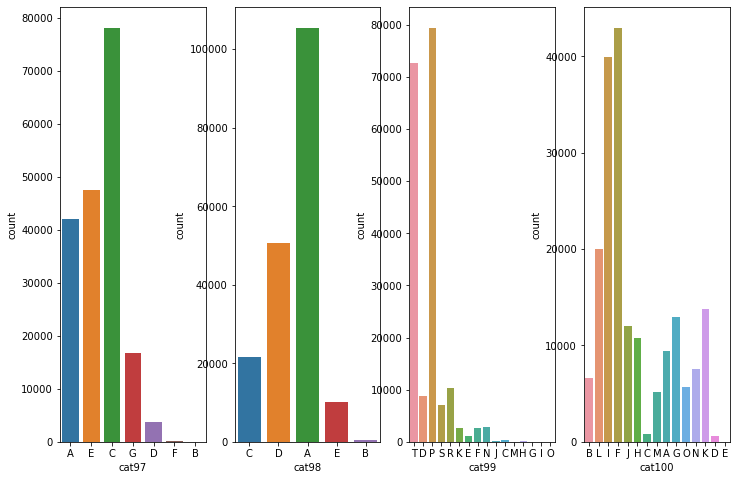

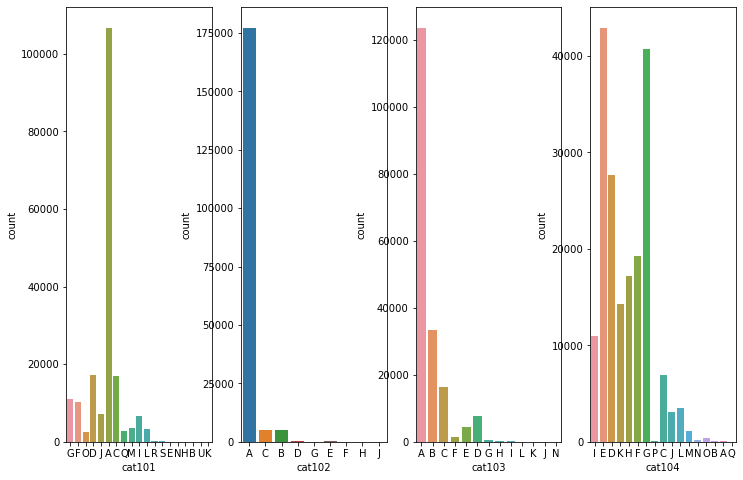

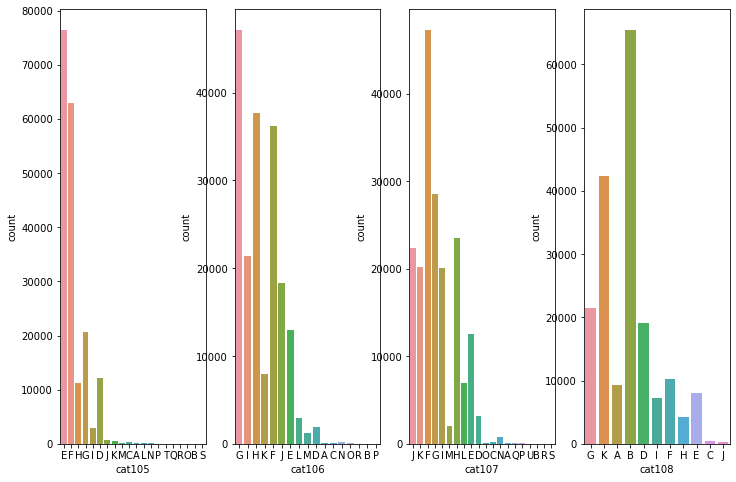

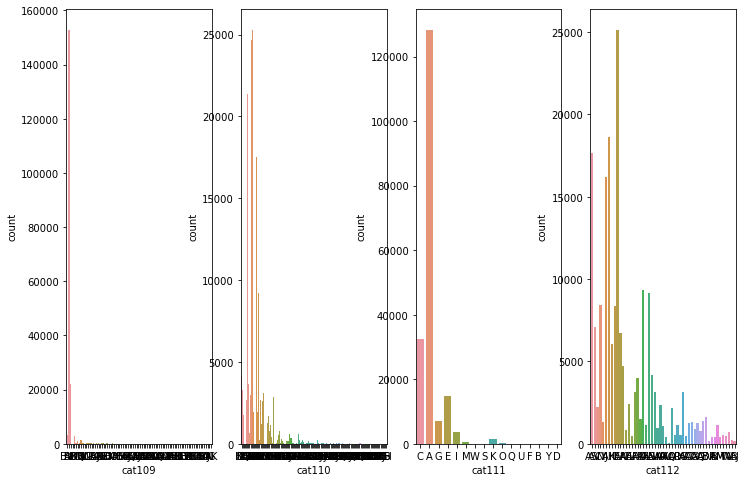

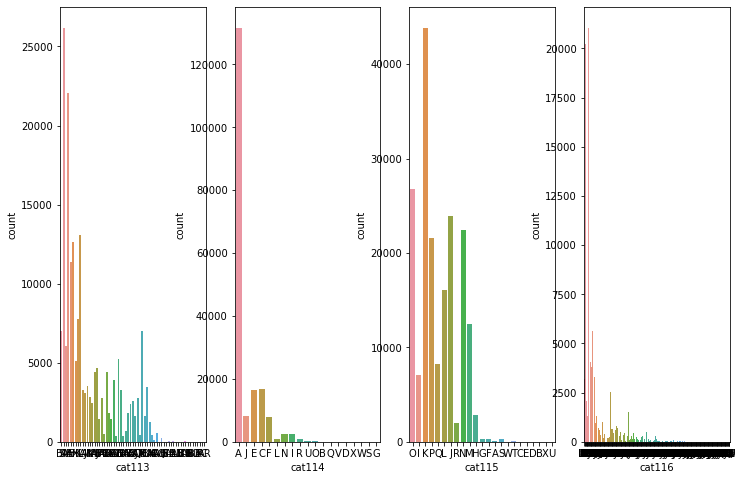

In [28]:
#Plot count plot for all attributes in a 29x4 grid
n_cols = 4
n_rows = 29
for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(12, 8))
    for j in range(n_cols):
        sns.countplot(x=cat_cols[i*n_cols+j], data=train_data, ax=ax[j])

#cat1 to cat72 have only two labels A and B. In most of the cases, B has very few entries
#cat73 to cat 108 have more than two labels
#cat109 to cat116 have many labels

In [29]:
# Plot violin for all attributes in a 7x2 grid
# violin plot: a combination of box and density plots
n_cols = 2
n_rows = 7

for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(12, 8))
    for j in range(n_cols):
        sns.violinplot(y=con_cols[i*n_cols+j], data=train_data, ax=ax[j])

NameError: name 'train' is not defined

In [ ]:
sns.violinplot(data=train,y=train["loss"])
plt.show()

In [ ]:
#log1p function applies log(1+x) to all elements of the column
loss = np.log1p(train["loss"])
sns.violinplot(data=train,y=loss)
plt.show()

# Plot shows that skew is corrected to a large extent

In [ ]:
corrmat = train[con_cols].corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))
# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

Strong correlation is observed between several pairs. <br/>
This represents an opportunity to reduce the feature set through transformations such as PCA. <br/>

## Categorical features 
### 1. Label Encoding (Factorizing)

In [ ]:
LBL = preprocessing.LabelEncoder()
start=time.time()
LE_map=dict()
for cat_col in cat_cols:
    full_data[cat_col] = LBL.fit_transform(full_data[cat_col])
    LE_map[cat_col]=dict(zip(LBL.classes_, LBL.transform(LBL.classes_)))
print ('Label enconding finished in %f seconds' % (time.time()-start))

In [ ]:
LE_map

### 2. One Hot Encoding (get dummies)

OHE can be done by either Pandas' get_dummies() or SK Learn's OneHotEncoder. 

* get_dummies is easier to implement (can be used directly on raw categorical features, i.e. strings), but it takes longer time and is not memory efficient.

* OneHotEncoder requires the features being converted to numeric, which has already been done by LabelEncoder in previous step, and is much more efficient (7x faster).

* We will convert the OHE's results to a sparse matrix which uses way less memory as compared to dense matrix. However, not all algorithms and packagers support sparse matrix, e.g. Keras. In that case, we'll need to use other tricks to make it work.

In [ ]:
OHE = preprocessing.OneHotEncoder(sparse=True)
start=time.time()
full_data_sparse=OHE.fit_transform(full_data[cat_cols])
print ('One-hot-encoding finished in %f seconds' % (time.time()-start))

print (full_data_sparse.shape)

In [ ]:
'''
column1: a, b, c, c, a,b,b,b,d,e,f,g,
label: 0,1,2,2,0,1,1,1
onehot: column1_a, column1_b, column1_c,,,,
            1          0         0
            0          1         0
            0          0         1

'''
    

## Numeric features

We will apply two preprocessings on numeric features:

1. Apply box-cox transformations for skewed numeric features.

2. Scale numeric features so they will fall in the range between 0 and 1.

**Calculate skewness of each numeric features:**

In [ ]:
from scipy.stats import skew, boxcox
skewed_cols = full_data[con_cols].apply(lambda x: skew(x.dropna()))
print (skewed_cols.sort_values())

**Apply box-cox transformations:**

In [ ]:
threshold = 0.15
skewed_cols = skewed_cols[abs(skewed_cols) > threshold].index.values
for skewed_col in skewed_cols:
    full_data[skewed_col], lam = boxcox(full_data[skewed_col] + 1)

**Apply Standard Scaling:**

In [ ]:
SSL = preprocessing.StandardScaler()
for con_col in con_cols:
     full_data[con_col] = SSL.fit_transform(full_data[con_col].values.reshape(-1,1))

## Model Building: Xgboost

In [ ]:
from scipy import sparse
full_data_sparse = sparse.hstack((full_data_sparse,full_data[con_cols]), format='csr')
print (full_data_sparse.shape)

In [ ]:
train_x = full_data_sparse[:train_size]
test_x = full_data_sparse[train_size:]
train_y = np.log(full_data[:train_size].loss.values + 200)
ID = full_data.id[:train_size].values


In [ ]:
def logregobj(labels, preds):
    con = 2
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess 

def log_mae(y,yhat):
    return mean_absolute_error(np.exp(y), np.exp(yhat))

log_mae_scorer = metrics.make_scorer(log_mae, greater_is_better = False)

In [ ]:
def search_model(train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
##Grid Search for the best model
    model = GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring    = log_mae_scorer,
                                     verbose    = 10,
                                     n_jobs  = n_jobs,
                                     iid        = True,
                                     refit    = refit,
                                     cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    print("Scores:", model.grid_scores_)
    return model

In [ ]:
param_grid = {'objective':[logregobj],
              'learning_rate':[0.02, 0.04, 0.06, 0.08],
              'n_estimators':[1500],
              'max_depth': [9],
              'min_child_weight':[50],
              'subsample': [0.78],
              'colsample_bytree':[0.67],
              'gamma':[0.9],
              'nthread': [-1],
              'seed' : [1234]}

model = search_model(train_x,
                     train_y,
                     xgb.XGBRegressor(),
                     param_grid,
                     n_jobs = 1,
                     cv = 4,
                     refit = True)

In [ ]:
rgr = xgb.XGBRegressor(seed = 1234, 
                       learning_rate = 0.01, # smaller, better results, more time
                       n_estimators = 1500, # Number of boosted trees to fit.
                       max_depth=9, # the maximum depth of a tree
                       min_child_weight=50,
                       colsample_bytree=0.67, # the fraction of columns to be randomly samples for each tree
                       subsample=0.78, # the fraction of observations to be randomly samples for each tree
                       gamma=0.9, # Minimum loss reduction required to make a further partition on a leaf node of the tree, 
                       # the larger, the more conservative 
                       nthread = -1, # Number of parallel threads used to run xgboost.
                       silent = False # Whether to print messages while running boosting.
                      )
rgr.fit(train_x, train_y)

In [ ]:
pred_y = np.exp(rgr.predict(test_x)) - 200

results = pd.DataFrame()
results['id'] = full_data[train_size:].id
results['loss'] = pred_y
results.to_csv("output/sub.csv", index=False)
print ("Submission created.")

In [ ]:
plt.bar(range(len(rgr.feature_importances_)), rgr.feature_importances_)
plt.show()

In [ ]:
xgb.plot_importance(rgr,max_num_features=5,importance_type='weight')

In [ ]:
np.argsort(rgr.feature_importances_)